In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [2]:
# 正负样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0, 1.0, size=[n_positive, 1])
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis=1)
Yp = torch.ones_like(r_p)

# 生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0, 1.0, size=[n_negative, 1])
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis=1)
Yn = torch.zeros_like(r_n)

# 汇总样本
X = torch.cat([Xp, Xn], axis=0)
Y = torch.cat([Yp, Yn], axis=0)


<Figure size 432x288 with 0 Axes>

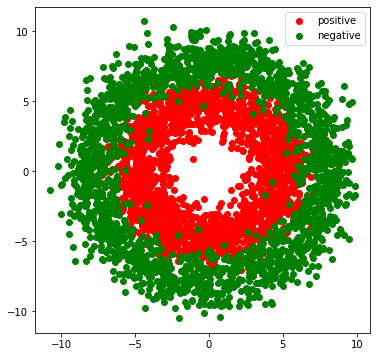

In [3]:
# 可视化
plt.clf()
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c="r")
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c="g")
plt.legend(["positive", "negative"])
# plt.savefig("./dnn_test_raw.png")
plt.show()

In [4]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)


# 测试数据管道效果
batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tensor([[-4.6522,  1.2448],
        [-0.4231, -5.4234],
        [ 0.6889, -4.1967],
        [-2.1229,  6.9828],
        [ 1.1719,  8.1696],
        [ 6.3048,  3.8412],
        [ 6.5394,  1.1554],
        [ 4.1297, -2.8531]])
tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]])


In [5]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2, 4))
        self.b1 = nn.Parameter(torch.zeros(1, 4))
        self.w2 = nn.Parameter(torch.randn(4, 8))
        self.b2 = nn.Parameter(torch.zeros(1, 8))
        self.w3 = nn.Parameter(torch.randn(8, 1))
        self.b3 = nn.Parameter(torch.zeros(1, 1))

    # 正向传播
    def forward(self, x):
        x = torch.relu(x @ self.w1 + self.b1)
        x = torch.relu(x @ self.w2 + self.b2)
        y = torch.sigmoid(x @ self.w3 + self.b3)
        return y

    # 损失函数(二元交叉熵)
    def loss_func(self, y_pred, y_true):
        # 将预测值限制在1e-7以上, 1- (1e-7)以下，避免log(0)错误
        eps = 1e-7
        y_pred = torch.clamp(y_pred, eps, 1.0 - eps)
        bce = - y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)
        return torch.mean(bce)

    # 评估指标(准确率)
    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(y_pred > 0.5, torch.ones_like(y_pred, dtype=torch.float32),
                             torch.zeros_like(y_pred, dtype=torch.float32))
        acc = torch.mean(1 - torch.abs(y_true - y_pred))
        return acc
        
model = DNNModel()

In [6]:
# 测试模型结构
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))

predictions = model(features)

loss = model.loss_func(labels, predictions)
metric = model.metric_func(labels, predictions)

print("init loss:", loss.item())
print("init metric:", metric.item())

init loss: 5.732353210449219
init metric: 0.6430714726448059


In [7]:
# 打印时间
import datetime


def print_bar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "==========" * 8 + "%s" % nowtime)


def train_step(model, features, labels):
    # 正向传播求损失
    features = features.to(device)
    labels = labels.to(device)
    model = model.to(device)
    predictions = model.forward(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)

    # 反向传播求梯度
    loss.backward()

    # 梯度下降法更新参数
    for param in model.parameters():
        # 注意是对param.data进行重新赋值,避免此处操作引起梯度记录
        # param.data = (param.data - 0.01 * param.grad.data)
        with torch.no_grad():
            param -= 0.01 * param.grad

        # 梯度清零
    model.zero_grad()
    return loss.item(), metric.item()


def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        loss_list, metric_list = [], []
        for features, labels in data_iter(X, Y, 20):
            features.to(device)
            labels.to(device)
            lossi, metrici = train_step(model, features, labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch % 100 == 0:
            print_bar()
            print("epoch =", epoch, "loss = ", loss, "metric = ", metric)

model = model.to(device)
train_model(model, epochs=500)


================================================================================2022-03-13 21:37:16
epoch = 100 loss =  0.19827325079590083 metric =  0.9242500084638595

================================================================================2022-03-13 21:38:30
epoch = 200 loss =  0.19069937812164425 metric =  0.9240000107884407

================================================================================2022-03-13 21:39:35
epoch = 300 loss =  0.18051471719983966 metric =  0.9282500091195106

================================================================================2022-03-13 21:40:41
epoch = 400 loss =  0.1763887820811942 metric =  0.9295000091195107

================================================================================2022-03-13 21:41:47
epoch = 500 loss =  0.17394351542228834 metric =  0.9350000068545341


<Figure size 432x288 with 0 Axes>

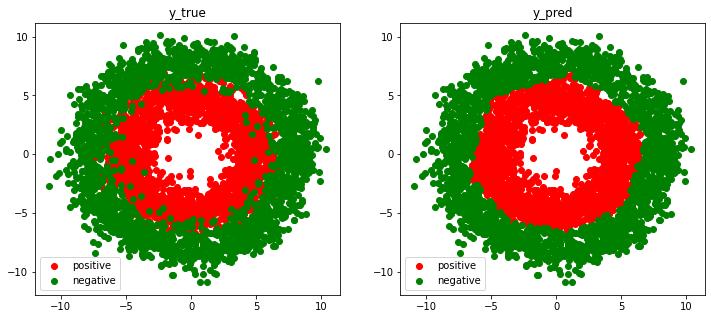

In [10]:
# 结果可视化
plt.clf()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c="r")
ax1.scatter(Xn[:, 0], Xn[:, 1], c="g")
ax1.legend(["positive", "negative"])
ax1.set_title("y_true")

Xp_pred = X[torch.squeeze(model.forward(X) >= 0.5)]
Xn_pred = X[torch.squeeze(model.forward(X) < 0.5)]

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c="r")
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c="g")
ax2.legend(["positive", "negative"])
ax2.set_title("y_pred")
plt.show()
